<a href="https://colab.research.google.com/github/trinaxavier2001/SkinLesionClassification/blob/main/ResNet50_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torchvision


In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.metrics         import accuracy_score, f1_score

from torch.utils.data      import Dataset, DataLoader
from torchvision           import transforms
from torchvision.models    import resnet50, ResNet50_Weights
from torch.cuda.amp        import autocast, GradScaler

In [2]:
# ─── CONFIG ────────────────────────────────────────────────────────────────
BASE_DIR    = '/content/drive/MyDrive/Skin_Disease_Model'
CSV_PATH    = os.path.join(BASE_DIR, 'metadata_with_image_descriptions.csv')
BATCH_SIZE  = 32
NUM_EPOCHS  = 26
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Optional: enforce full determinism (may slow some CUDA ops)



In [3]:
from pathlib import Path
import glob

# ─── CONFIG ────────────────────────────────────────────────────────────────
# adjust this to wherever you mounted your Drive in Colab
DRIVE_ROOT = Path("/content/drive/MyDrive/Skin_Disease_Model")

# ─── 1) PREPARE A GLOBAL IMAGE-ID → FILE-PATH MAP ──────────────────────────
# scan both parts directories for all .jpg files
all_image_files = glob.glob(str(DRIVE_ROOT / "HAM10000_images_part_*" / "*.jpg"))

# build a dict { image_id (no suffix) : absolute_path_str }
path_map = { Path(p).stem : p for p in all_image_files }


# ─── 2) HELPERS ───────────────────────────────────────────────────────────────
def preprocess_df(csv_path):
    df = pd.read_csv(csv_path)

    # map each image_id to its full path via our dict
    df["file_path"] = df["image_id"].map(path_map)

    # if any lookups failed, you'll get NaNs—catch them early:
    missing = df["file_path"].isna().sum()
    if missing:
        raise RuntimeError(f"{missing} image_ids not found in Drive!")

    # encode labels
    df["label"] = LabelEncoder().fit_transform(df["dx"])
    return df

def make_splits(df):
    df_temp, test_df = train_test_split(
        df, test_size=0.10,
        stratify=df["label"],
        random_state=42
    )
    val_ratio = 0.20 / 0.90
    train_df, val_df = train_test_split(
        df_temp, test_size=val_ratio,
        stratify=df_temp["label"],
        random_state=42
    )
    return train_df, val_df, test_df


In [4]:

class HAM10000Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df        = df.reset_index(drop=True)
        self.transform = transform
        labels = sorted(self.df.label.unique())
        self.label_map = {lbl:i for i,lbl in enumerate(labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.file_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row.label]
        return img, label

In [5]:
# ─── TRANSFORMS ────────────────────────────────────────────────────────────
heavy_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.2)),
])

val_test_tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

def make_loaders(train_df, val_df, test_df, batch_size=BATCH_SIZE):
    # compute class weights
    counts = train_df.label.value_counts().sort_index().values
    class_weights = counts.max() / counts
    class_weights /= class_weights.mean()

    # build datasets
    train_ds = HAM10000Dataset(train_df, transform=heavy_augment)
    val_ds   = HAM10000Dataset(val_df,   transform=val_test_tfm)
    test_ds  = HAM10000Dataset(test_df,  transform=val_test_tfm)

    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=2)
    val_loader   = DataLoader(val_ds,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=1)
    test_loader  = DataLoader(test_ds,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=1)

    return train_loader, val_loader, test_loader, \
           torch.as_tensor(class_weights, dtype=torch.float32)

In [7]:
# ─── MODEL ────────────────────────────────────────────────────────────────
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, dropout_p=0.5):
        super().__init__()
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_feats = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.head = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)

In [8]:
# ─── TRAIN ONE EPOCH (with periodic logging) ────────────────────────────────
def train_one_epoch(model, loader, criterion, optimizer, device, scaler, epoch, log_interval=100):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch_idx, (imgs, labels) in enumerate(loader, start=1):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            logits = model(imgs)
            loss   = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # ─── log every `log_interval` batches ───────────────────────────
        if batch_idx % log_interval == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:02d} | "
                  f"Batch {batch_idx}/{len(loader)} | "
                  f"LR {current_lr:.2e} | "
                  f"Batch Loss {loss.item():.4f}")

    torch.cuda.empty_cache()
    train_loss = total_loss / len(loader.dataset)
    train_acc  = accuracy_score(all_labels, all_preds)
    train_f1   = f1_score(all_labels, all_preds, average='macro')
    return train_loss, train_acc, train_f1

@torch.no_grad()
def validate(model, loader, criterion, device, scaler):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with autocast():
            logits = model(imgs)
            loss   = criterion(logits, labels)

        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    torch.cuda.empty_cache()
    val_loss = total_loss / len(loader.dataset)
    val_acc  = accuracy_score(all_labels, all_preds)
    val_f1   = f1_score(all_labels, all_preds, average='macro')
    return val_loss, val_acc, val_f1

In [9]:
import torch
torch.cuda.empty_cache()


In [11]:
# ─── MAIN TRAINING LOOP (call updated train_one_epoch) ─────────────────────
def run_training():
    torch.cuda.empty_cache()

    # Prepare data
    df           = preprocess_df(CSV_PATH)
    train_df, val_df, test_df = make_splits(df)
    train_loader, val_loader, test_loader, class_wts = make_loaders(
        train_df, val_df, test_df, batch_size=BATCH_SIZE
    )
    num_classes = class_wts.numel()

    # Build model & tools
    alpha     = class_wts.to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=alpha)
    model     = ModifiedResNet50(num_classes=num_classes).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=1e-5,     # start low for warm-up
                                  weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=3)
    scaler = GradScaler()

    # Freeze backbone initially
    for p in model.backbone.parameters():
        p.requires_grad = False

    best_acc = 0.0

    for ep in range(1, NUM_EPOCHS+1):
        # … (freeze/unfreeze, LR warm-up, transforms) …
        if ep == 6:
            for p in model.backbone.parameters():
                p.requires_grad = True
            print("🔓 Unfroze backbone")
        target_lr = 1e-4 if ep > 2 else 1e-5 * (ep/2)
        for g in optimizer.param_groups:
            g['lr'] = target_lr
        if ep <= 3:
            train_loader.dataset.transform = val_test_tfm
        else:
            train_loader.dataset.transform = heavy_augment

        # pass `epoch` into train_one_epoch:
        tr_loss, tr_acc, tr_f1 = train_one_epoch(
            model, train_loader, criterion,
            optimizer, DEVICE, scaler,
            epoch=ep,        # <-- here
            log_interval=100 # adjust as desired
        )

        val_loss, val_acc, val_f1 = validate(
            model, val_loader, criterion,
            DEVICE, scaler
        )

        scheduler.step(val_loss)

        print(f"Epoch {ep:02d} | "
              f"Train L {tr_loss:.4f} Acc {tr_acc:.4f} F1 {tr_f1:.4f} | "
              f"Val   L {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50.pth')

    print(f"\nBest validation accuracy: {best_acc:.4f}")


In [12]:

if __name__ == "__main__":
    run_training()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]
<ipython-input-11-4ac7b3816b96>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Batch 100/220 | LR 5.00e-06 | Batch Loss 1.9908
Epoch 01 | Batch 200/220 | LR 5.00e-06 | Batch Loss 1.8915


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01 | Train L 1.9406 Acc 0.2869 F1 0.1265 | Val   L 1.9304 Acc 0.4718 F1 0.1536


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | Batch 100/220 | LR 1.00e-05 | Batch Loss 1.8867
Epoch 02 | Batch 200/220 | LR 1.00e-05 | Batch Loss 1.8918


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02 | Train L 1.9210 Acc 0.4613 F1 0.1705 | Val   L 1.9027 Acc 0.6470 F1 0.2037


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | Batch 100/220 | LR 1.00e-04 | Batch Loss 1.8417
Epoch 03 | Batch 200/220 | LR 1.00e-04 | Batch Loss 1.5633


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03 | Train L 1.7788 Acc 0.5842 F1 0.2883 | Val   L 1.6317 Acc 0.6355 F1 0.3623


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | Batch 100/220 | LR 1.00e-04 | Batch Loss 1.8813
Epoch 04 | Batch 200/220 | LR 1.00e-04 | Batch Loss 1.4258


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04 | Train L 1.6202 Acc 0.5773 F1 0.3224 | Val   L 1.4893 Acc 0.6360 F1 0.4144


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | Batch 100/220 | LR 1.00e-04 | Batch Loss 1.3126
Epoch 05 | Batch 200/220 | LR 1.00e-04 | Batch Loss 1.6444


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05 | Train L 1.4804 Acc 0.5775 F1 0.3547 | Val   L 1.4036 Acc 0.6490 F1 0.4381
🔓 Unfroze backbone


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | Batch 100/220 | LR 1.00e-04 | Batch Loss 1.1387
Epoch 06 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.9464


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 06 | Train L 1.1171 Acc 0.6394 F1 0.4694 | Val   L 0.8657 Acc 0.6760 F1 0.5419


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.4900
Epoch 07 | Batch 200/220 | LR 1.00e-04 | Batch Loss 1.0547


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 07 | Train L 0.8391 Acc 0.6767 F1 0.5456 | Val   L 0.7027 Acc 0.7449 F1 0.6254


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | Batch 100/220 | LR 1.00e-04 | Batch Loss 1.3824
Epoch 08 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.8184


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 08 | Train L 0.6735 Acc 0.7260 F1 0.6403 | Val   L 0.8441 Acc 0.7958 F1 0.6173


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.7892
Epoch 09 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.5797


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 09 | Train L 0.6251 Acc 0.7466 F1 0.6339 | Val   L 0.6557 Acc 0.7768 F1 0.6504


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.4711
Epoch 10 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.2029


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Train L 0.5343 Acc 0.7629 F1 0.6790 | Val   L 0.6228 Acc 0.8133 F1 0.6801


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.3927
Epoch 11 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.5104


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Train L 0.4679 Acc 0.7864 F1 0.7197 | Val   L 0.7417 Acc 0.7404 F1 0.6852


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.2977
Epoch 12 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.5320


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Train L 0.4127 Acc 0.8006 F1 0.7468 | Val   L 0.6776 Acc 0.8043 F1 0.6892


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.1951
Epoch 13 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.3910


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Train L 0.3840 Acc 0.8044 F1 0.7306 | Val   L 0.6924 Acc 0.8078 F1 0.7257


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.3059
Epoch 14 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.2340


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Train L 0.3937 Acc 0.8244 F1 0.7609 | Val   L 0.6774 Acc 0.8323 F1 0.7278


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.6172
Epoch 15 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.1941


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Train L 0.3342 Acc 0.8352 F1 0.7883 | Val   L 0.7343 Acc 0.8148 F1 0.6966


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.7360
Epoch 16 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.8888


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Train L 0.2942 Acc 0.8526 F1 0.8191 | Val   L 0.6697 Acc 0.8283 F1 0.7545


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.3552
Epoch 17 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.6482


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Train L 0.3158 Acc 0.8471 F1 0.7945 | Val   L 0.6909 Acc 0.8253 F1 0.7241


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.0826
Epoch 18 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.1173


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Train L 0.2690 Acc 0.8655 F1 0.8276 | Val   L 0.8306 Acc 0.8517 F1 0.7737


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.7669
Epoch 19 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.1282


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Train L 0.2360 Acc 0.8729 F1 0.8477 | Val   L 0.6959 Acc 0.8467 F1 0.7853


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.3464
Epoch 20 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.2587


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Train L 0.1956 Acc 0.8874 F1 0.8689 | Val   L 0.7573 Acc 0.8168 F1 0.7503


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.0368
Epoch 21 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.3708


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Train L 0.2044 Acc 0.8923 F1 0.8689 | Val   L 0.8235 Acc 0.8288 F1 0.7476


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.5217
Epoch 22 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.1726


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Train L 0.2180 Acc 0.8860 F1 0.8530 | Val   L 0.7776 Acc 0.8447 F1 0.7355


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.5307
Epoch 23 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.0937


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Train L 0.2132 Acc 0.8884 F1 0.8483 | Val   L 0.8288 Acc 0.8153 F1 0.7446


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.0654
Epoch 24 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.1220


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Train L 0.2310 Acc 0.8777 F1 0.8432 | Val   L 0.8676 Acc 0.7903 F1 0.6983


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.1831
Epoch 25 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.2752


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Train L 0.2128 Acc 0.8810 F1 0.8538 | Val   L 0.8444 Acc 0.8362 F1 0.7421


<ipython-input-8-20985f93b7e0>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26 | Batch 100/220 | LR 1.00e-04 | Batch Loss 0.0765
Epoch 26 | Batch 200/220 | LR 1.00e-04 | Batch Loss 0.3936


<ipython-input-8-20985f93b7e0>:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26 | Train L 0.2481 Acc 0.8816 F1 0.8503 | Val   L 0.7977 Acc 0.8507 F1 0.7336

Best validation accuracy: 0.8517


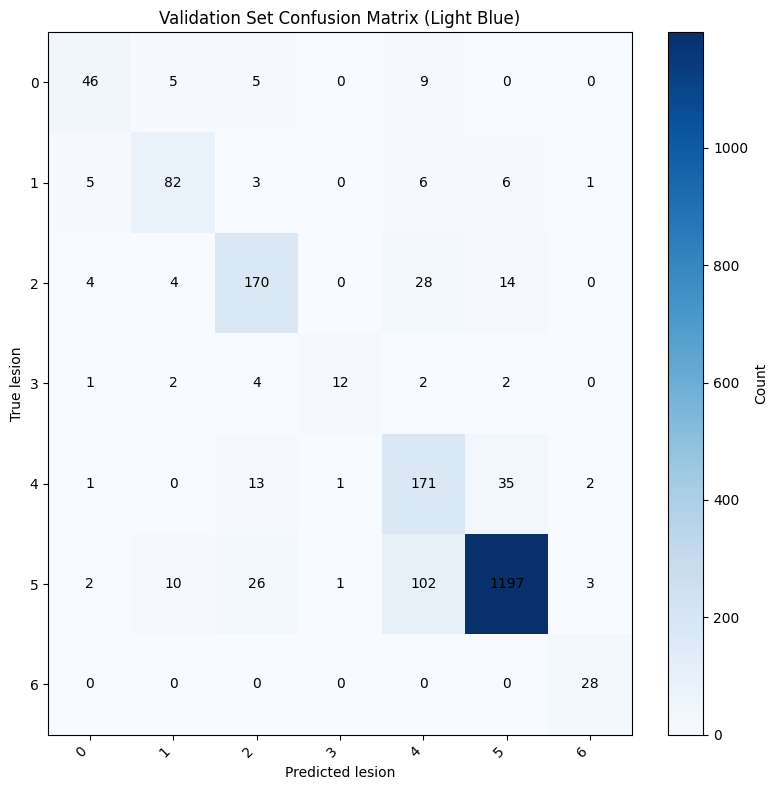

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Rebuild your splits & loaders
df = preprocess_df(CSV_PATH)
train_df, val_df, test_df = make_splits(df)
_, val_loader, _, class_wts = make_loaders(train_df, val_df, test_df,
                                           batch_size=BATCH_SIZE)

# 2) Reload your trained model weights
model = ModifiedResNet50(num_classes=class_wts.numel()).to(DEVICE)
model.load_state_dict(torch.load('best_resnet50.pth', map_location=DEVICE))
model.eval()

# 3) Inference on the validation set
all_preds_val, all_labels_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        all_preds_val .extend(preds.cpu().tolist())
        all_labels_val.extend(yb.cpu().tolist())

# 4) Compute confusion matrix
cm_val = confusion_matrix(all_labels_val, all_preds_val)

# 5) Recover lesion codes from val_loader.dataset.label_map
inv_map = {idx: orig for orig, idx in val_loader.dataset.label_map.items()}
n       = cm_val.shape[0]
lesions = [inv_map[i] for i in range(n)]

# 6) Plot with a light “Blues” colormap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_val, interpolation='nearest', aspect='auto', cmap='Blues')
plt.colorbar(im, ax=ax, label='Count')

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(lesions, rotation=45, ha='right')
ax.set_yticklabels(lesions)

for i in range(n):
    for j in range(n):
        ax.text(j, i, cm_val[i, j], ha='center', va='center')

ax.set_xlabel('Predicted lesion')
ax.set_ylabel('True lesion')
ax.set_title('Validation Set Confusion Matrix (Light Blue)')
plt.tight_layout()
plt.show()


In [16]:
import torch
from torch.utils.data      import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score

# 1) Re-load your full dataframe & make the same splits
full_df    = preprocess_df(CSV_PATH)            # same helper you used above
_, val_df, test_df = make_splits(full_df)       # returns train/val/test

# 2) Instantiate the test‐loader
test_ds     = HAM10000Dataset(test_df, transform=val_test_tfm)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# 3) Rebuild your model architecture & load best weights
model = ModifiedResNet50(num_classes=len(full_df.label.unique())).to(DEVICE)
model.load_state_dict(torch.load('best_resnet50.pth', map_location=DEVICE))
model.eval()

# 4) Run inference over the test‐loader
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        preds  = logits.argmax(dim=1)
        all_preds .extend(preds.cpu().tolist())
        all_labels.extend(yb.cpu().tolist())

# 5) Compute your four metrics
acc  = accuracy_score(all_labels, all_preds) * 100
prec = precision_score(all_labels, all_preds, average="macro") * 100
rec  = recall_score(all_labels, all_preds, average="macro") * 100
f1   = f1_score(all_labels, all_preds, average="macro") * 100

# 6) Print “Table VI” exactly as you want it
print("TABLE VI  RESULTS FROM STAGE 1")
print("| Exp |   Model    | Accuracy | Precision | Recall | F1-score |")
print("|:---:|:-----------|:--------:|:---------:|:------:|:--------:|")
print(f"| 6   | ResNet-50  |  {acc:5.1f}%  |   {prec:5.1f}%   |  {rec:5.1f}% |  {f1:5.1f}%   |")


TABLE VI  RESULTS FROM STAGE 1
| Exp |   Model    | Accuracy | Precision | Recall | F1-score |
|:---:|:-----------|:--------:|:---------:|:------:|:--------:|
| 6   | ResNet-50  |   85.1%  |    80.2%   |   79.8% |   79.4%   |


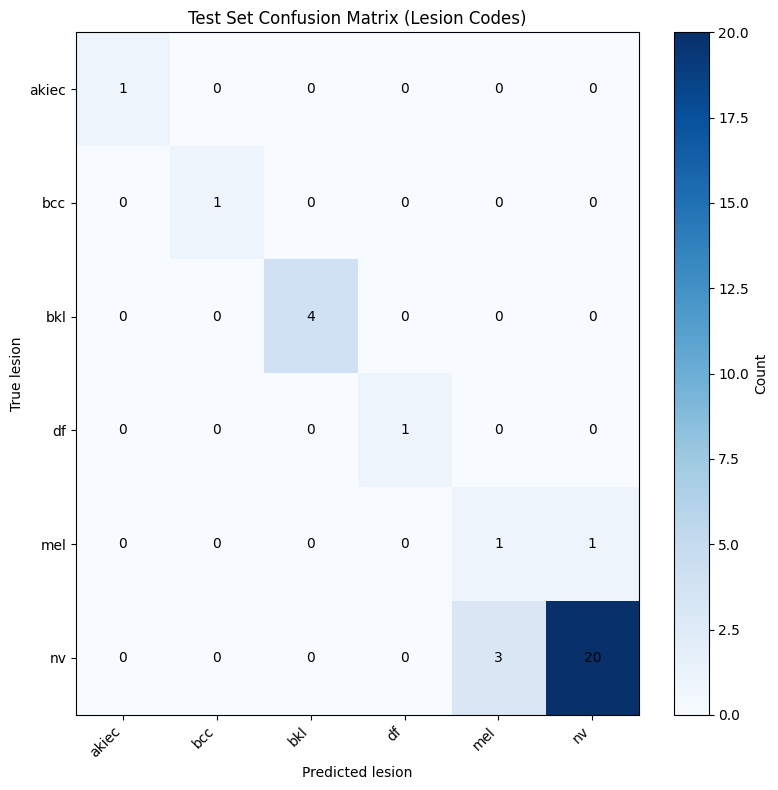

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# — after your inference, with all_labels, all_preds and test_ds already defined —

# 1) Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 2) Re-load your full df and rebuild the LabelEncoder you used for `df["label"]`
df_le = pd.read_csv(CSV_PATH)
le    = LabelEncoder().fit(df_le["dx"])       # now le.classes_ == array of your lesion codes

# 3) Number of classes in the matrix
n = cm.shape[0]

# 4) Get the first n class names in encoder order
class_names = le.inverse_transform(np.arange(n))

# 5) Plot with a light “Blues” colormap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', aspect='auto', cmap='Blues')
plt.colorbar(im, ax=ax, label='Count')

# 6) Tick marks + the real lesion codes
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# 7) Annotate each cell with the count
for i in range(n):
    for j in range(n):
        ax.text(j, i, cm[i, j], ha='center', va='center')

ax.set_xlabel('Predicted lesion')
ax.set_ylabel('True lesion')
ax.set_title('Test Set Confusion Matrix (Lesion Codes)')
plt.tight_layout()
plt.show()
